## 1.Imports

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import json

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve,
)

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup

import random
from sklearn.utils.class_weight import compute_class_weight

import optuna

## 2. Downloads and Data Preparation


In [4]:
training_labels= pd.read_excel("/content/drive/MyDrive/training_labels_final_comments.xlsx")
validation_labels= pd.read_excel("/content/drive/MyDrive/validation_labels_final_comments.xlsx")

In [5]:
#remove "" from the beginning and the end of each speech content
training_labels['speech_content'] = training_labels['speech_content'].str.replace(r'^["„“]|["„“]$', '', regex=True)
validation_labels['speech_content'] = validation_labels['speech_content'].str.replace(r'^["„“]|["„“]$', '', regex=True)

In [7]:
polarizing_sample_size = training_labels['polarizing'].sum()
neutral_sample_size = training_labels['neutral'].sum()
populist_sample_size = training_labels['populist'].sum()

print(f"Polarizing Sample Size: {polarizing_sample_size}")
print(f"Neutral Sample Size: {neutral_sample_size}")
print(f"Populist Sample Size: {populist_sample_size}")

Polarizing Sample Size: 824
Neutral Sample Size: 3943
Populist Sample Size: 348


In [9]:
# Polarizing Corpus Sampling
# Sample polarizing and non-polarizing statements equal to the polarizing sample size (824)
neutral_df_train_polarizing = training_labels[training_labels['neutral'] == 1]
sample_neutral_train_polarizing = neutral_df_train_polarizing.sample(n=polarizing_sample_size, random_state=42)

sample_polarizing_train = training_labels[training_labels['polarizing'] == 1]
sampled_df_train_polarizing = pd.concat([sample_neutral_train_polarizing, sample_polarizing_train])
len(sampled_df_train_polarizing)

1648

## 3.Tokenization, Padding and Truncation

In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

def encode(data, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in data['speech_content']:
        encoded = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt',
            return_attention_mask=True
        )

        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))

    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)

    return input_ids, attention_masks

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

In [16]:
# Tokenization for Polarizing Corpus
train_input_ids_polarizing, train_attention_masks_polarizing = encode(sampled_df_train_polarizing, tokenizer)
val_input_ids_polarizing, val_attention_masks_polarizing = encode(validation_labels, tokenizer)

# Checking tokenized sequence lengths for polarizing corpus
train_lengths_polarizing = train_input_ids_polarizing.size(1)
val_lengths_polarizing = val_input_ids_polarizing.size(1)

print("Polarizing Train Length:", train_lengths_polarizing)
print("Polarizing Validation Length:", val_lengths_polarizing)


Polarizing Train Length: 128
Polarizing Validation Length: 128


## 4. Train BERT model with Corpus

In [17]:
# Define FocalLoss class
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        """
        Focal Loss for binary classification.

        Args:
            alpha (float): Weighting factor for the class. Adjusts the importance of positive vs negative examples.
            gamma (float): Focusing parameter. Higher gamma focuses more on hard examples.
            reduction (str): Specifies the reduction to apply to the output: 'none' | 'mean' | 'sum'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        # Compute the binary cross-entropy loss with logits
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, reduction='none'
        )
        # Apply sigmoid to logits to get probabilities
        probs = torch.sigmoid(logits)
        # Compute the focal loss factor
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_factor = self.alpha * (1 - pt) ** self.gamma
        # Apply the focal factor to the loss
        loss = focal_factor * bce_loss
        # Reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss



In [18]:
#define functions
def initialize_model(learning_rate, pre_trained_model, dropout_prob=0.3, num_labels=1):
    # Initialize the model with custom dropout probabilities
    model = BertForSequenceClassification.from_pretrained(
        pre_trained_model,
        num_labels=num_labels,
        hidden_dropout_prob=dropout_prob,  # Dropout for hidden layers
        attention_probs_dropout_prob=dropout_prob  # Dropout for attention layers
    )
    model.to(device)

    # Initialize the optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    return model, optimizer

def compute_class_weights(labels):
    class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
    return torch.tensor(class_weights, dtype=torch.float).to(device)

def train_one_epoch(model, dataloader, optimizer, scheduler, criterion):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits.squeeze(-1)
        loss = criterion(logits, batch_labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, threshold=0.5):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            batch_input_ids, batch_attention_masks, batch_labels = [b.to(device) for b in batch]
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
            logits = outputs.logits.squeeze(-1)
            loss = criterion(logits, batch_labels)
            val_loss += loss.item()

            # Apply sigmoid and use threshold for predictions
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    # Return average validation loss, predictions, and labels
    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss, all_preds, all_labels

### 4.1 Build Base Model

In [ ]:
# Build base model with initial default parameters
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Labels for training and validation
labels_train = sampled_df_train_polarizing['polarizing'].astype(int).values
labels_val = validation_labels['polarizing'].astype(int).values

learning_rate = 1e-6
warmup_steps = 0
epochs = 3
batch_size = 32

# Initialize model, optimizer, and criterion
baseline_model, optimizer = initialize_model(learning_rate = learning_rate, pre_trained_model= "bert-base-german-cased", dropout_prob= 0)
class_weights = compute_class_weights(labels_train)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

# Create Dataloaders for final training
train_dataset = TensorDataset(train_input_ids_polarizing, train_attention_masks_polarizing, torch.tensor(labels_train).float().to(device))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids_polarizing, val_attention_masks_polarizing, torch.tensor(labels_val).float().to(device))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=len(train_dataloader) * epochs)

# Training loop
for epoch in range(epochs):
    train_loss = train_one_epoch(baseline_model, train_dataloader, optimizer, scheduler, criterion)
    val_loss, all_preds, all_labels = validate(baseline_model, val_dataloader, criterion, threshold=0.5)
    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - Training Loss: 0.6602 - Validation Loss: 0.6006
Epoch 2/3 - Training Loss: 0.6211 - Validation Loss: 0.5852
Epoch 3/3 - Training Loss: 0.5997 - Validation Loss: 0.5779


### 4.2 Hyperparameter Tuning & Fine-Tuning


#### 4.2.1 Hyperparameter Tuning with Focal Loss

In [ ]:
# Using Optuna to find the best hyperparamters to improve model performance using Focal Loss as Loss function

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Labels for training and validation
labels_train = sampled_df_train_polarizing['polarizing'].astype(int).values
labels_val = validation_labels['polarizing'].astype(int).values

# Optuna objective function
def objective_focal_loss(trial):
    # Define hyperparameters from Optuna
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    epochs = trial.suggest_int("epochs", 5, 10)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.2)
    dropout_prob = trial.suggest_float("dropout_prob", 0.1, 0.5)

    # Suggest alpha and gamma for Focal Loss
    alpha = trial.suggest_float("alpha", 0.25, 1.0)
    gamma = trial.suggest_float("gamma", 1.0, 5.0)


    # Calculate total steps and warmup steps
    total_steps = len(train_input_ids_polarizing) * epochs
    warmup_steps = int(total_steps * warmup_ratio)

    # Create the dataset and dataloaders
    train_dataset = TensorDataset(train_input_ids_polarizing, train_attention_masks_polarizing, torch.tensor(labels_train).float().to(device))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(val_input_ids_polarizing, val_attention_masks_polarizing, torch.tensor(labels_val).float().to(device))
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model, optimizer, and criterion
    model, optimizer = initialize_model(learning_rate=learning_rate, pre_trained_model="bert-base-german-cased", dropout_prob=dropout_prob)
    criterion = FocalLoss(alpha=alpha, gamma=gamma)

    # Initialize scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    # Early stopping parameters
    best_val_loss = float("inf")
    no_improvement_epochs = 0

    # Training loop
    for epoch in range(epochs):
        # Calculate the average training loss
        avg_train_loss = train_one_epoch(model, train_dataloader, optimizer, scheduler, criterion)

        val_loss, all_preds, all_labels = validate(model, val_dataloader, criterion, threshold=0.8)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= 3:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # Print progress with correctly defined average losses
        print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    return best_val_loss


# Run Optuna study
study_focal_loss = optuna.create_study(direction="minimize")
study_focal_loss.optimize(objective_focal_loss, n_trials=5)


[I 2024-11-12 16:15:36,696] A new study created in memory with name: no-name-b795ea54-14b2-477d-820c-013f3ad5b1f3
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6 - Training Loss: 0.0126 - Validation Loss: 0.0049
Epoch 2/6 - Training Loss: 0.0105 - Validation Loss: 0.0051
Epoch 3/6 - Training Loss: 0.0093 - Validation Loss: 0.0044
Epoch 4/6 - Training Loss: 0.0086 - Validation Loss: 0.0035
Epoch 5/6 - Training Loss: 0.0079 - Validation Loss: 0.0030


[I 2024-11-12 16:21:24,132] Trial 0 finished with value: 0.002576107967788084 and parameters: {'learning_rate': 1.7471550463965897e-06, 'batch_size': 8, 'epochs': 6, 'warmup_ratio': 0.1558064286982542, 'dropout_prob': 0.31667649831437317, 'alpha': 0.4060251925650857, 'gamma': 4.870972803846547}. Best is trial 0 with value: 0.002576107967788084.


Epoch 6/6 - Training Loss: 0.0068 - Validation Loss: 0.0026


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Training Loss: 0.2481 - Validation Loss: 0.2415
Epoch 2/10 - Training Loss: 0.1901 - Validation Loss: 0.1455
Epoch 3/10 - Training Loss: 0.1315 - Validation Loss: 0.0711
Epoch 4/10 - Training Loss: 0.0893 - Validation Loss: 0.1215
Epoch 5/10 - Training Loss: 0.0624 - Validation Loss: 0.0569
Epoch 6/10 - Training Loss: 0.0404 - Validation Loss: 0.0716
Epoch 7/10 - Training Loss: 0.0206 - Validation Loss: 0.0655


[I 2024-11-12 16:29:06,735] Trial 1 finished with value: 0.05687668275371088 and parameters: {'learning_rate': 7.181887871403741e-06, 'batch_size': 8, 'epochs': 10, 'warmup_ratio': 0.14397869073700062, 'dropout_prob': 0.12343279351913683, 'alpha': 0.8550054649183767, 'gamma': 1.4470538503602342}. Best is trial 0 with value: 0.002576107967788084.


Early stopping at epoch 8


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/9 - Training Loss: 0.1817 - Validation Loss: 0.1389
Epoch 2/9 - Training Loss: 0.1792 - Validation Loss: 0.1441
Epoch 3/9 - Training Loss: 0.1727 - Validation Loss: 0.1410
Epoch 4/9 - Training Loss: 0.1688 - Validation Loss: 0.1334
Epoch 5/9 - Training Loss: 0.1611 - Validation Loss: 0.1176
Epoch 6/9 - Training Loss: 0.1509 - Validation Loss: 0.1017
Epoch 7/9 - Training Loss: 0.1357 - Validation Loss: 0.0882
Epoch 8/9 - Training Loss: 0.1192 - Validation Loss: 0.0675


[I 2024-11-12 16:36:36,469] Trial 2 finished with value: 0.05189404783534332 and parameters: {'learning_rate': 6.539943897122264e-06, 'batch_size': 32, 'epochs': 9, 'warmup_ratio': 0.09411411908573052, 'dropout_prob': 0.3490055087522138, 'alpha': 0.6210587786491538, 'gamma': 1.3124934052897537}. Best is trial 0 with value: 0.002576107967788084.


Epoch 9/9 - Training Loss: 0.0985 - Validation Loss: 0.0519


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/9 - Training Loss: 0.0305 - Validation Loss: 0.0190
Epoch 2/9 - Training Loss: 0.0241 - Validation Loss: 0.0109
Epoch 3/9 - Training Loss: 0.0176 - Validation Loss: 0.0084
Epoch 4/9 - Training Loss: 0.0157 - Validation Loss: 0.0075
Epoch 5/9 - Training Loss: 0.0160 - Validation Loss: 0.0084
Epoch 6/9 - Training Loss: 0.0134 - Validation Loss: 0.0059
Epoch 7/9 - Training Loss: 0.0107 - Validation Loss: 0.0065
Epoch 8/9 - Training Loss: 0.0117 - Validation Loss: 0.0092


[I 2024-11-12 16:44:06,124] Trial 3 finished with value: 0.00586719723569203 and parameters: {'learning_rate': 7.901641026371278e-05, 'batch_size': 32, 'epochs': 9, 'warmup_ratio': 0.023875898779428195, 'dropout_prob': 0.4823385790793404, 'alpha': 0.2584318096905236, 'gamma': 2.8618662704248687}. Best is trial 0 with value: 0.002576107967788084.


Early stopping at epoch 9


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6 - Training Loss: 0.0575 - Validation Loss: 0.0326
Epoch 2/6 - Training Loss: 0.0449 - Validation Loss: 0.0259
Epoch 3/6 - Training Loss: 0.0393 - Validation Loss: 0.0190
Epoch 4/6 - Training Loss: 0.0311 - Validation Loss: 0.0123
Epoch 5/6 - Training Loss: 0.0254 - Validation Loss: 0.0106


[I 2024-11-12 16:49:53,519] Trial 4 finished with value: 0.01044520020218362 and parameters: {'learning_rate': 3.2036570402294023e-06, 'batch_size': 8, 'epochs': 6, 'warmup_ratio': 0.08678420951499961, 'dropout_prob': 0.3690041492124597, 'alpha': 0.7968031451077466, 'gamma': 3.6275950416844434}. Best is trial 0 with value: 0.002576107967788084.


Epoch 6/6 - Training Loss: 0.0224 - Validation Loss: 0.0104


In [ ]:
best_trial_focal_loss = study_focal_loss.best_trial  # Now you can access the best_trial
best_params_focal_loss = best_trial_focal_loss.params

print(f"Best Trial: {best_trial_focal_loss}")
print(f"Best Parameters: {best_params_focal_loss}")


Best Trial: FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.002576107967788084], datetime_start=datetime.datetime(2024, 11, 12, 16, 15, 36, 698779), datetime_complete=datetime.datetime(2024, 11, 12, 16, 21, 24, 132472), params={'learning_rate': 1.7471550463965897e-06, 'batch_size': 8, 'epochs': 6, 'warmup_ratio': 0.1558064286982542, 'dropout_prob': 0.31667649831437317, 'alpha': 0.4060251925650857, 'gamma': 4.870972803846547}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0001, log=True, low=1e-06, step=None), 'batch_size': CategoricalDistribution(choices=(8, 16, 32)), 'epochs': IntDistribution(high=10, log=False, low=5, step=1), 'warmup_ratio': FloatDistribution(high=0.2, log=False, low=0.0, step=None), 'dropout_prob': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'alpha': FloatDistribution(high=1.0, log=False, low=0.25, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=1.0, step=N

#### 4.2.2 Hyperparameter Tuning with Logits Loss

In [ ]:
# Using Optuna to find the best hyperparamters to improve model performance using Logits Loss as Loss function
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Labels for training and validation
labels_train = sampled_df_train_polarizing['polarizing'].astype(int).values
labels_val = validation_labels['polarizing'].astype(int).values

# Optuna objective function
def objective_logit_loss(trial):
    # Define hyperparameters from Optuna
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    epochs = trial.suggest_int("epochs", 5, 10)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.2)
    dropout_prob = trial.suggest_float("dropout_prob", 0.1, 0.5)

    # Calculate total steps and warmup steps
    total_steps = len(train_input_ids_polarizing) * epochs
    warmup_steps = int(total_steps * warmup_ratio)

    # Create the dataset and dataloaders
    train_dataset = TensorDataset(train_input_ids_polarizing, train_attention_masks_polarizing, torch.tensor(labels_train).float().to(device))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(val_input_ids_polarizing, val_attention_masks_polarizing, torch.tensor(labels_val).float().to(device))
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model, optimizer, and criterion
    model_logit_loss, optimizer = initialize_model(learning_rate=learning_rate, pre_trained_model="bert-base-german-cased", dropout_prob=dropout_prob)
    class_weights = compute_class_weights(labels_train)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

    # Initialize scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    # Early stopping parameters
    best_val_loss = float("inf")
    no_improvement_epochs = 0

    # Training loop
    for epoch in range(epochs):
        # Calculate the average training loss
        avg_train_loss = train_one_epoch(model_logit_loss, train_dataloader, optimizer, scheduler, criterion)

        # Calculate validation loss with threshold 0.8
        val_loss, all_preds, all_labels = validate(model_logit_loss, val_dataloader, criterion, threshold=0.8)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= 3:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # Print progress with correctly defined average losses
        print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    return best_val_loss


# Run Optuna study
study_logit_loss = optuna.create_study(direction="minimize")
study_logit_loss.optimize(objective_logit_loss, n_trials=5)


[I 2024-11-13 11:29:20,160] A new study created in memory with name: no-name-5ce90d84-206b-44fd-8edd-a9a94ab85531
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Training Loss: 0.6972 - Validation Loss: 0.7381
Epoch 2/5 - Training Loss: 0.6914 - Validation Loss: 0.7292
Epoch 3/5 - Training Loss: 0.6860 - Validation Loss: 0.7168
Epoch 4/5 - Training Loss: 0.6839 - Validation Loss: 0.6939


[I 2024-11-13 11:33:14,856] Trial 0 finished with value: 0.6706204162517064 and parameters: {'learning_rate': 2.2147036374473165e-06, 'batch_size': 32, 'epochs': 5, 'warmup_ratio': 0.18541524747713772, 'dropout_prob': 0.24323233567684946}. Best is trial 0 with value: 0.6706204162517064.


Epoch 5/5 - Training Loss: 0.6753 - Validation Loss: 0.6706


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6 - Training Loss: 0.6931 - Validation Loss: 0.5878
Epoch 2/6 - Training Loss: 0.6048 - Validation Loss: 0.3633
Epoch 3/6 - Training Loss: 0.3864 - Validation Loss: 0.2039
Epoch 4/6 - Training Loss: 0.2689 - Validation Loss: 0.1553
Epoch 5/6 - Training Loss: 0.2088 - Validation Loss: 0.1375


[I 2024-11-13 11:37:55,405] Trial 1 finished with value: 0.13679890044059762 and parameters: {'learning_rate': 4.172976828501959e-05, 'batch_size': 32, 'epochs': 6, 'warmup_ratio': 0.06323976214908038, 'dropout_prob': 0.3264154065503213}. Best is trial 1 with value: 0.13679890044059762.


Epoch 6/6 - Training Loss: 0.1417 - Validation Loss: 0.1368


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6 - Training Loss: 0.6374 - Validation Loss: 0.4334
Epoch 2/6 - Training Loss: 0.3609 - Validation Loss: 0.1524
Epoch 3/6 - Training Loss: 0.2430 - Validation Loss: 0.1541
Epoch 4/6 - Training Loss: 0.1436 - Validation Loss: 0.1210
Epoch 5/6 - Training Loss: 0.1043 - Validation Loss: 0.1335


[I 2024-11-13 11:43:20,335] Trial 2 finished with value: 0.12096899304236203 and parameters: {'learning_rate': 1.3715645070874099e-05, 'batch_size': 8, 'epochs': 6, 'warmup_ratio': 0.05903380674890089, 'dropout_prob': 0.2880393421002361}. Best is trial 2 with value: 0.12096899304236203.


Epoch 6/6 - Training Loss: 0.0507 - Validation Loss: 0.2650


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Training Loss: 0.7052 - Validation Loss: 0.5754
Epoch 2/10 - Training Loss: 0.6056 - Validation Loss: 0.3713
Epoch 3/10 - Training Loss: 0.4122 - Validation Loss: 0.2123
Epoch 4/10 - Training Loss: 0.3091 - Validation Loss: 0.1545
Epoch 5/10 - Training Loss: 0.2691 - Validation Loss: 0.1509
Epoch 6/10 - Training Loss: 0.2235 - Validation Loss: 0.1382
Epoch 7/10 - Training Loss: 0.1581 - Validation Loss: 0.1397
Epoch 8/10 - Training Loss: 0.1337 - Validation Loss: 0.1853


[I 2024-11-13 11:50:57,724] Trial 3 finished with value: 0.13821334564979648 and parameters: {'learning_rate': 8.120301389690587e-05, 'batch_size': 16, 'epochs': 10, 'warmup_ratio': 0.18513793046954868, 'dropout_prob': 0.3892402745555201}. Best is trial 2 with value: 0.12096899304236203.


Early stopping at epoch 9


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6 - Training Loss: 0.7085 - Validation Loss: 0.7791
Epoch 2/6 - Training Loss: 0.7022 - Validation Loss: 0.7688
Epoch 3/6 - Training Loss: 0.6955 - Validation Loss: 0.7542
Epoch 4/6 - Training Loss: 0.6921 - Validation Loss: 0.7306
Epoch 5/6 - Training Loss: 0.6843 - Validation Loss: 0.7091


[I 2024-11-13 11:56:02,851] Trial 4 finished with value: 0.6909809200696542 and parameters: {'learning_rate': 1.2446335324199702e-06, 'batch_size': 16, 'epochs': 6, 'warmup_ratio': 0.13428408976974623, 'dropout_prob': 0.4036883269422201}. Best is trial 2 with value: 0.12096899304236203.


Epoch 6/6 - Training Loss: 0.6815 - Validation Loss: 0.6910


In [ ]:
#print best parameters
best_trial_logit_loss = study_logit_loss.best_trial
best_params_logit_loss = best_trial_logit_loss.params

print(f"Best Trial:{best_trial_logit_loss}")
print(f"Best Parameters:{best_params_logit_loss}")

Best Trial:FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.12096899304236203], datetime_start=datetime.datetime(2024, 11, 13, 11, 37, 55, 407026), datetime_complete=datetime.datetime(2024, 11, 13, 11, 43, 20, 335399), params={'learning_rate': 1.3715645070874099e-05, 'batch_size': 8, 'epochs': 6, 'warmup_ratio': 0.05903380674890089, 'dropout_prob': 0.2880393421002361}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0001, log=True, low=1e-06, step=None), 'batch_size': CategoricalDistribution(choices=(8, 16, 32)), 'epochs': IntDistribution(high=10, log=False, low=5, step=1), 'warmup_ratio': FloatDistribution(high=0.2, log=False, low=0.0, step=None), 'dropout_prob': FloatDistribution(high=0.5, log=False, low=0.1, step=None)}, trial_id=2, value=None)
Best Parameters:{'learning_rate': 1.3715645070874099e-05, 'batch_size': 8, 'epochs': 6, 'warmup_ratio': 0.05903380674890089, 'dropout_prob': 0.2880393421002361}


### 4.3 Train Model with Best Parameters

#### 4.3.1 Train Model with Best Parameters Focal Loss

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labels_train = sampled_df_train_polarizing['polarizing'].astype(int).values
labels_val = validation_labels['polarizing'].astype(int).values

# Define parameters from Optuna
best_learning_rate = best_trial_focal_loss.params["learning_rate"]
best_batch_size = best_trial_focal_loss.params["batch_size"]
best_epochs = best_trial_focal_loss.params["epochs"]
best_warmup_ratio = best_trial_focal_loss.params["warmup_ratio"]
dropout_prob = best_trial_focal_loss.params["dropout_prob"]
best_alpha = best_trial_focal_loss.params["alpha"]
best_gamma = best_trial_focal_loss.params["gamma"]

# Initialize model, optimizer, and criterion
model_focal_loss, optimizer = initialize_model(
    best_learning_rate,
    pre_trained_model="bert-base-german-cased",
    dropout_prob=dropout_prob
)

# Initialize criterion with FocalLoss
criterion = FocalLoss(alpha=best_alpha, gamma=best_gamma)

# Create Dataloaders for final training
train_dataset = TensorDataset(
    train_input_ids_polarizing,
    train_attention_masks_polarizing,
    torch.tensor(labels_train).float().to(device)
)
train_dataloader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)

val_dataset = TensorDataset(
    val_input_ids_polarizing,
    val_attention_masks_polarizing,
    torch.tensor(labels_val).float().to(device)
)
val_dataloader = DataLoader(val_dataset, batch_size=best_batch_size)

# Initialize scheduler
total_steps = len(train_dataloader) * best_epochs
warmup_steps = int(total_steps * best_warmup_ratio)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Early stopping parameters
patience = 3  # Number of epochs with no improvement to wait before stopping
best_val_loss = float("inf")
no_improvement_epochs = 0

# Training loop with early stopping
for epoch in range(best_epochs):
    train_loss = train_one_epoch(model_focal_loss, train_dataloader, optimizer, scheduler, criterion)
    val_loss, all_preds, all_labels = validate(model_focal_loss, val_dataloader, criterion, threshold=0.8)

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0  # Reset counter
    else:
        no_improvement_epochs += 1

    print(f"Epoch {epoch + 1}/{best_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    # Early stopping condition
    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6 - Training Loss: 0.0149 - Validation Loss: 0.0152
Epoch 2/6 - Training Loss: 0.0109 - Validation Loss: 0.0078
Epoch 3/6 - Training Loss: 0.0086 - Validation Loss: 0.0061
Epoch 4/6 - Training Loss: 0.0078 - Validation Loss: 0.0047
Epoch 5/6 - Training Loss: 0.0071 - Validation Loss: 0.0043
Epoch 6/6 - Training Loss: 0.0070 - Validation Loss: 0.0041


#### 4.3.2 Train Model with Best Paramters Logits Loss

In [19]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define parameters from Optuna
best_learning_rate_logit_loss = best_trial_logit_loss.params["learning_rate"]
best_batch_size_logit_loss = best_trial_logit_loss.params["batch_size"]
best_epochs_logit_loss = best_trial_logit_loss.params["epochs"]
best_warmup_ratio_logit_loss = best_trial_logit_loss.params["warmup_ratio"]
dropout_prob_logit_loss = best_trial_logit_loss.params["dropout_prob"]

# Initialize model, optimizer, and criterion
model_logit_loss, optimizer = initialize_model(
    best_learning_rate_logit_loss,
    pre_trained_model="bert-base-german-cased",
    dropout_prob=dropout_prob_logit_loss
)

class_weights = compute_class_weights(labels_train)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

# Create Dataloaders for final training
train_dataset = TensorDataset(
    train_input_ids_polarizing,
    train_attention_masks_polarizing,
    torch.tensor(labels_train).float().to(device)
)
train_dataloader = DataLoader(train_dataset, batch_size=best_batch_size_logit_loss, shuffle=True)

val_dataset = TensorDataset(
    val_input_ids_polarizing,
    val_attention_masks_polarizing,
    torch.tensor(labels_val).float().to(device)
)
val_dataloader = DataLoader(val_dataset, batch_size=best_batch_size_logit_loss)

# Initialize scheduler
total_steps = len(train_dataloader) * best_epochs_logit_loss
warmup_steps = int(total_steps * best_warmup_ratio_logit_loss)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Early stopping parameters
patience = 3  # Number of epochs with no improvement to wait before stopping
best_val_loss = float("inf")
no_improvement_epochs = 0

# Training loop with early stopping
for epoch in range(best_epochs_logit_loss):
    train_loss = train_one_epoch(model_logit_loss, train_dataloader, optimizer, scheduler, criterion)
    val_loss, all_preds, all_labels = validate(model_logit_loss, val_dataloader, criterion, threshold=0.8)

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0  # Reset counter
    else:
        no_improvement_epochs += 1

    print(f"Epoch {epoch + 1}/{best_epochs_logit_loss} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    # Early stopping condition
    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6 - Training Loss: 0.4690 - Validation Loss: 0.1475
Epoch 2/6 - Training Loss: 0.2308 - Validation Loss: 0.1234
Epoch 3/6 - Training Loss: 0.1423 - Validation Loss: 0.1249
Epoch 4/6 - Training Loss: 0.0758 - Validation Loss: 0.1335
Epoch 5/6 - Training Loss: 0.0548 - Validation Loss: 0.1381
Early stopping triggered after 5 epochs


## 5. Evaluate Model Performance

In [25]:
def evaluate_model(model, input_ids, attention_masks, threshold, labels, label_name="Label"):
    model.eval()  # Set the model to evaluation mode

    dataset = TensorDataset(input_ids, attention_masks, labels)
    dataloader = DataLoader(dataset, batch_size=16)

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            batch_input_ids, batch_attention_masks, batch_labels = [b.to(device) for b in batch]
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
            logits = outputs.logits.squeeze(-1)

            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_probs)
    class_report = classification_report(all_labels, all_preds, zero_division=0)

    print(f"{label_name} - Accuracy: {accuracy:.4f}")
    print(f"{label_name} - Precision: {precision:.4f}")
    print(f"{label_name} - Recall: {recall:.4f}")
    print(f"{label_name} - F1-Score: {f1:.4f}")
    print(f"{label_name} - ROC-AUC Score: {roc_auc:.4f}")
    print(f"\n{label_name} - Classification Report:\n{class_report}")

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{label_name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(False)
    plt.show()

    # Return metrics and predictions
    return accuracy, precision, recall, f1, roc_auc, all_preds, all_labels

### 5.1 Evaluate Non-Fine-Tuned BERT

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Non-Fine-Tuned BERT - Accuracy: 0.2065
Non-Fine-Tuned BERT - Precision: 0.0911
Non-Fine-Tuned BERT - Recall: 0.7565
Non-Fine-Tuned BERT - F1-Score: 0.1627
Non-Fine-Tuned BERT - ROC-AUC Score: 0.4083

Non-Fine-Tuned BERT - Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.14      0.25      2027
         1.0       0.09      0.76      0.16       230

    accuracy                           0.21      2257
   macro avg       0.47      0.45      0.20      2257
weighted avg       0.76      0.21      0.24      2257



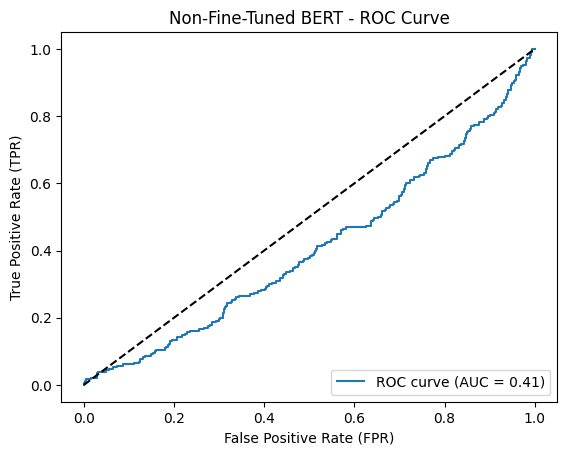

In [42]:
# Test BERT on validation set without beeing fine-tuned on corpus
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained BERT model without fine-tuning
model_bert = BertForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=1)
model_bert.to(device)

# Tokenizer setup
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

# Create a DataLoader for the test data
val_dataset = TensorDataset(val_input_ids_polarizing, val_attention_masks_polarizing, torch.tensor(labels_val).float().to(device))
val_dataloader = DataLoader(val_dataset, batch_size=8)

# Run evaluation on the validation set
accuracy, precision, recall, f1, roc_auc, all_preds, all_labels = evaluate_model(
    model_bert,
    val_input_ids_polarizing.to(device),
    val_attention_masks_polarizing.to(device),
    0.5,
    torch.tensor(labels_val).float().to(device),
    label_name="Non-Fine-Tuned BERT"
)


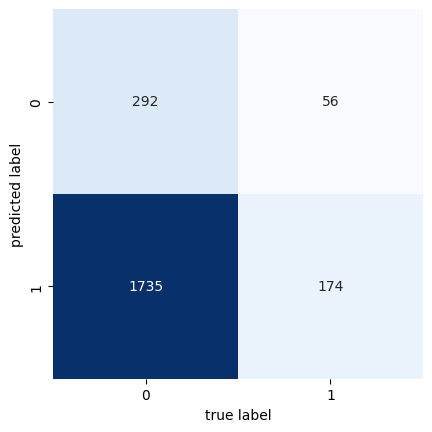

In [43]:
# confusion matrix non-fine-tuned BERT
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()

# plot it as 2d matrix
mat= confusion_matrix(all_labels, all_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap = "Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()



### 5.2 Evaluate Base Model Performance

Polarizing Evaluation Baseline Model - Accuracy: 0.8773
Polarizing Evaluation Baseline Model - Precision: 0.4467
Polarizing Evaluation Baseline Model - Recall: 0.8565
Polarizing Evaluation Baseline Model - F1-Score: 0.5872
Polarizing Evaluation Baseline Model - ROC-AUC Score: 0.9403

Polarizing Evaluation Baseline Model - Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      2027
         1.0       0.45      0.86      0.59       230

    accuracy                           0.88      2257
   macro avg       0.71      0.87      0.76      2257
weighted avg       0.93      0.88      0.89      2257



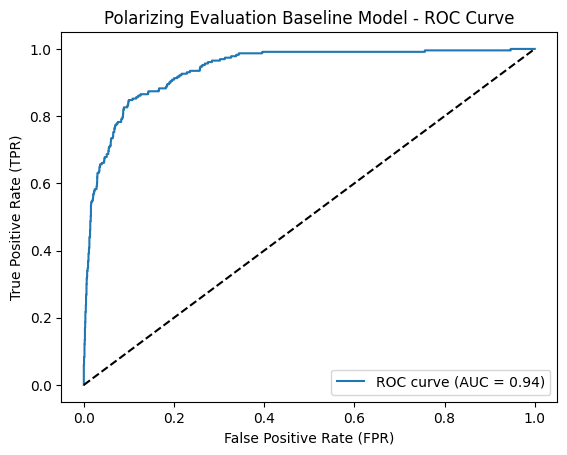

In [ ]:
#print evaluation results for base line model

accuracy_baseline, precision_baseline, recall_baseline, f1_baseline, roc_auc_baseline, all_preds_baseline, all_labels_baseline = evaluate_model(
    baseline_model,
    val_input_ids_polarizing,
    val_attention_masks_polarizing,
    threshold=0.5,
    labels=torch.tensor(validation_labels['polarizing'].values).float(),
    label_name="Polarizing Evaluation Baseline Model"
)


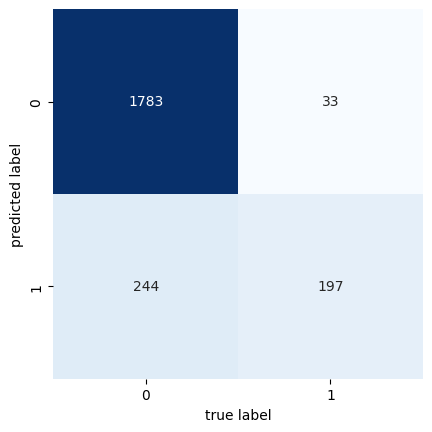

In [ ]:
# confusion matrix base line model
tn_baseline, fp_baseline, fn_baseline, tp_baseline = confusion_matrix(all_labels_baseline, all_preds_baseline).ravel()

# plot it as 2d matrix
mat_baseline= confusion_matrix(all_labels_baseline, all_preds_baseline)
sns.heatmap(mat_baseline.T, square=True, annot=True, fmt='d', cbar=False, cmap = "Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()



### 5.3 Evaluate Fine-Tuned Model with Focal Loss Function




Polarizing Evaluation Focal Loss - Accuracy: 0.9140
Polarizing Evaluation Focal Loss - Precision: 0.5621
Polarizing Evaluation Focal Loss - Recall: 0.7087
Polarizing Evaluation Focal Loss - F1-Score: 0.6269
Polarizing Evaluation Focal Loss - ROC-AUC Score: 0.9276

Polarizing Evaluation Focal Loss - Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95      2027
         1.0       0.56      0.71      0.63       230

    accuracy                           0.91      2257
   macro avg       0.76      0.82      0.79      2257
weighted avg       0.92      0.91      0.92      2257



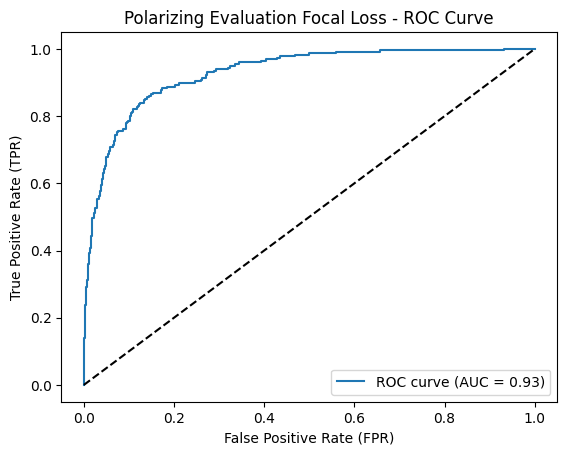

In [ ]:
# Print evaluation results for focal loss

accuracy_focal_loss, precision_focal_loss, recall_focal_loss, f1_focal_loss, roc_auc_focal_loss, all_preds_focal_loss, all_labels_focal_loss = evaluate_model(
    model_focal_loss,
    val_input_ids_polarizing,
    val_attention_masks_polarizing,
    threshold=0.5,
    labels=torch.tensor(validation_labels['polarizing'].values).float(),
    label_name="Polarizing Evaluation Focal Loss"
)


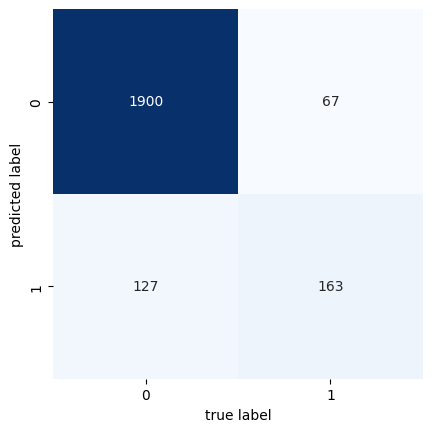

In [ ]:
# confusion matrix focal loss
tn_focal, fp_focal, fn_focal, tp_focal = confusion_matrix(all_labels_focal_loss, all_preds_focal_loss).ravel()

# plot it as 2d matrix
mat_focal_loss = confusion_matrix(all_labels_focal_loss, all_preds_focal_loss)
sns.heatmap(mat_focal_loss.T, square=True, annot=True, fmt='d', cbar=False, cmap = "Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()



### 5.4 Evaluate Fine-Tuned Model with Logits Loss Function


Polarizing Evaluation Logits Loss - Accuracy: 0.9473
Polarizing Evaluation Logits Loss - Precision: 0.7322
Polarizing Evaluation Logits Loss - Recall: 0.7609
Polarizing Evaluation Logits Loss - F1-Score: 0.7463
Polarizing Evaluation Logits Loss - ROC-AUC Score: 0.9696

Polarizing Evaluation Logits Loss - Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      2027
         1.0       0.73      0.76      0.75       230

    accuracy                           0.95      2257
   macro avg       0.85      0.86      0.86      2257
weighted avg       0.95      0.95      0.95      2257



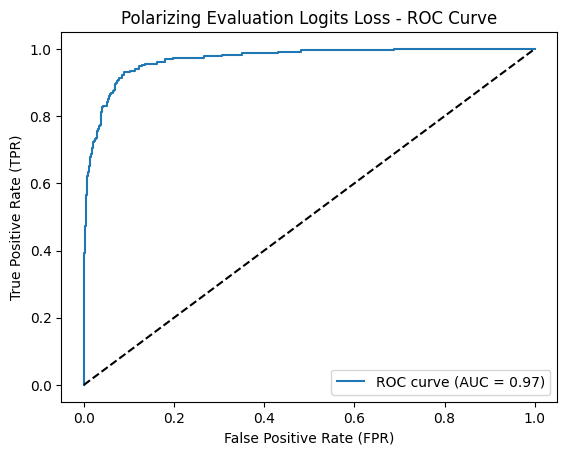

In [ ]:
# Print evaluation results for logits loss

accuracy_logits_loss, precision_logits_loss, recall_logits_loss, f1_logits_loss, roc_auc_logits_loss, all_preds_logits_loss, all_labels_logits_loss = evaluate_model(
    model_logit_loss,
    val_input_ids_polarizing,
    val_attention_masks_polarizing,
    threshold=0.8,
    labels=torch.tensor(validation_labels['polarizing'].values).float(),
    label_name="Polarizing Evaluation Logits Loss"
)


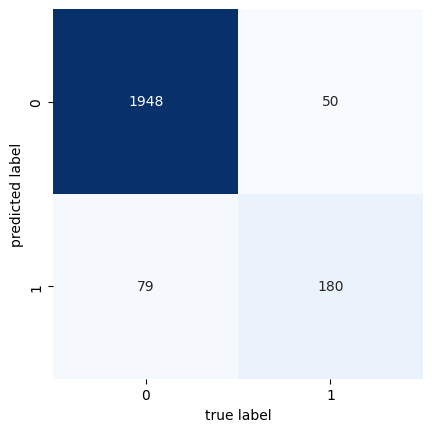

In [ ]:
# confusion matrix logits loss
tn_logit, fp_logit, fn_logit, tp_logit = confusion_matrix(all_labels_logits_loss, all_preds_logits_loss).ravel()

# plot it as 2d matrix
mat_logit_loss = confusion_matrix(all_labels_logits_loss, all_preds_logits_loss)
sns.heatmap(mat_logit_loss.T, square=True, annot=True, fmt='d', cbar=False, cmap = "Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()



## 6. Save Model for later re-use

In [ ]:
# save best model

# Combine predictions with the original validation data
validation_labels['predicted_polarizing'] = all_preds_logits_loss # Append predictions as a new column

# Save predictions to Excel
validation_labels.to_excel("/content/drive/My Drive/validation_predictions_optimized_optuna_logitsloss_final.xlsx", index=False)
print("Validation predictions saved to content/drive/My Drive/validation_predictions_optimized_optuna_logitsloss_final.xlsx")

# Save the trained model and tokenizer under the specified name
best_model_logits_loss = "/content/drive/My Drive/bert-base-german-cased_only_polarizing_optimized_optuna_logitloss_final"
model_logit_loss.save_pretrained(best_model_logits_loss)
tokenizer.save_pretrained(best_model_logits_loss)

print(f"Trained model and tokenizer saved to {best_model_logits_loss}")

# Save the parameters to a JSON file
with open(f"{best_model_logits_loss}/best_params_logit_loss.json", 'w') as fp:
    json.dump(best_params_logit_loss, fp)

print(f"Best hyperparameters saved to {best_model_logits_loss}/best_params_logit_loss.json")


Validation predictions saved to content/drive/My Drive/validation_predictions_optimized_optuna_logitsloss_final.xlsx
Trained model and tokenizer saved to /content/drive/My Drive/bert-base-german-cased_only_polarizing_optimized_optuna_logitloss_final
Best hyperparameters saved to /content/drive/My Drive/bert-base-german-cased_only_polarizing_optimized_optuna_logitloss_final/best_params_logit_loss.json
